<a href="https://colab.research.google.com/github/wander-asb/Customer_Segmentation/blob/main/Segmenta%C3%A7%C3%A3o_de_consumidores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas

In [185]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


from google.colab                import drive
import warnings
warnings.filterwarnings("ignore")

In [186]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [187]:
df_segmentacao = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/Segmentação de Clientes/online_retail_II.xlsx')
df_segmentacao.shape

(525461, 8)

In [188]:
df_segmentacao.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [189]:
df_segmentacao.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom


In [190]:
df_segmentacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


## Tratamento de dados

In [191]:
#Retiramos dados nulos de consumidores
df_segmentacao = df_segmentacao[~df_segmentacao['Customer ID'].isna()].drop('Description', axis=1)

In [192]:
#Verificamos que existem quantidades negativas de compras
df_segmentacao = df_segmentacao[~df_segmentacao['Quantity'] < 0]

In [193]:
#Intervalo de tempo da base de dados
df_segmentacao['InvoiceDate'].agg(['min', 'max'])

#A data máxima será a medida final do intervalo de recencia
data_máxima = max(df_segmentacao['InvoiceDate'])

In [194]:
#Excluir linhas com comportamento de quantidade de compra negativa, pode ser estorno
df_segmentacao = df_segmentacao[~df_segmentacao['Quantity'] < 0]

In [195]:
data_máxima

Timestamp('2010-12-09 20:01:00')

In [196]:
df_segmentacao['Customer ID'] = df_segmentacao['Customer ID'].astype(int).astype(str)
df_segmentacao.shape

(407695, 7)

In [197]:
#Quantidade de clientes únicos pertencentes a base de dados
len(df_segmentacao['Customer ID'].unique().tolist())

4314

In [198]:
df_segmentacao.dtypes

Invoice                object
StockCode              object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

In [199]:
#Criar análise de RFM para a base de clientes
df_segmentacao['Amount'] = df_segmentacao['Price'] * df_segmentacao['Quantity']

## RFM Analytcs

### Montante 

In [200]:
#Cria feature de montante transacionado
df_monetary = df_segmentacao.groupby('Customer ID')['Amount'].sum().reset_index().rename({'Amount':'Montante'}, axis = 1)

### Frequencia

In [201]:
#Cria feature de invoice consumida
df_frequency = df_segmentacao.groupby('Customer ID')['Invoice'].count().reset_index().rename({'Invoice':'Frequencia'}, axis = 1)

In [202]:
#Junta as features criadas logo acima
df = df_monetary.merge(df_frequency, on='Customer ID')

### Recencia

In [203]:
#Trazer feature de recência de cada consumidor
df_segmentacao['Recencia'] = data_máxima - df_segmentacao['InvoiceDate']

#Buscamos a data mínima em dias de cada cliente
df_recency = df_segmentacao.groupby('Customer ID')['Recencia'].min().reset_index()

#Tratamos a data
df_recency['Recencia'] = df_recency['Recencia'].dt.days

#Junta as features tratadas
df = df.merge(df_recency, on='Customer ID')

### Elasticidade

In [204]:
#Buscamos a data em dias da última compra do cliente
data_ultima_compra = df_segmentacao.groupby('Customer ID')['InvoiceDate'].max().reset_index()

#Renomeamos a coluna de InvoiceDate para "Data ultima compra"
data_ultima_compra = data_ultima_compra.rename(columns={'InvoiceDate':'Data ultima compra'})

In [205]:
#Buscamos a data em dias da primeira compra do cliente
data_primeira_compra = df_segmentacao.groupby('Customer ID')['InvoiceDate'].min().reset_index()

#Renomeamos a coluna de InvoiceDate para "Data ultima compra"
data_primeira_compra = data_primeira_compra.rename(columns={'InvoiceDate':'Data primeira compra'})

In [206]:
elasticidade = data_ultima_compra.merge(data_primeira_compra, on='Customer ID', how='left')

In [207]:
#Calculamos a feature de comprimento (elasticidade)
elasticidade['Elasticidade'] = elasticidade['Data ultima compra'] - elasticidade['Data primeira compra']

In [208]:
#Tratamos a data
elasticidade['Elasticidade'] = elasticidade['Elasticidade'].dt.days

In [209]:
#Junta as features tratadas
df = df.merge(elasticidade[['Customer ID','Elasticidade']], on='Customer ID')

# ATUALIZAR TABELA NO OVERLEAF DE PRIMEIROS CINCO AMOSTRAS E RFM DESCRIBE

## Remoção de outliers

In [210]:
rfm_dataframe = df[['Customer ID','Recencia','Frequencia','Montante']]
rfm_dataframe.head()

,Customer ID,Recencia,Frequencia,Montante
0,12346,164,33,372.86
1,12347,2,71,1323.32
2,12348,73,20,222.16
3,12349,42,102,2671.14
4,12351,10,21,300.93


#Remoção de outliers RFM

In [211]:
# Remoção de outliers
Q1 = rfm_dataframe.Montante.quantile(0.05)
Q3 = rfm_dataframe.Montante.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Montante >= Q1 - 1.5*IQR) & (rfm_dataframe.Montante <= Q3 + 1.5*IQR)].copy()

Q1 = rfm_dataframe.Recencia.quantile(0.05)
Q3 = rfm_dataframe.Recencia.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Recencia >= Q1 - 1.5*IQR) & (rfm_dataframe.Recencia <= Q3 + 1.5*IQR)].copy()

Q1 = rfm_dataframe.Frequencia.quantile(0.05)
Q3 = rfm_dataframe.Frequencia.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Frequencia >= Q1 - 1.5*IQR) & (rfm_dataframe.Frequencia <= Q3 + 1.5*IQR)].copy()

#Remoção de outliers RFME

In [212]:
rfme_dataframe = df[['Customer ID','Recencia','Frequencia','Montante','Elasticidade']]
rfme_dataframe.head()

,Customer ID,Recencia,Frequencia,Montante,Elasticidade
0,12346,164,33,372.86,196
1,12347,2,71,1323.32,37
2,12348,73,20,222.16,0
3,12349,42,102,2671.14,181
4,12351,10,21,300.93,0


In [213]:
# Remoção de outliers - Feature Montante
Q1 = rfme_dataframe.Montante.quantile(0.05)
Q3 = rfme_dataframe.Montante.quantile(0.95)
IQR = Q3 - Q1
rfme_dataframe = rfme_dataframe[(rfme_dataframe.Montante >= Q1 - 1.5*IQR) & (rfme_dataframe.Montante <= Q3 + 1.5*IQR)].copy()

In [214]:
# Remoção de outliers - Feature Recencia
Q1 = rfme_dataframe.Recencia.quantile(0.05)
Q3 = rfme_dataframe.Recencia.quantile(0.95)
IQR = Q3 - Q1
rfme_dataframe = rfme_dataframe[(rfme_dataframe.Recencia >= Q1 - 1.5*IQR) & (rfme_dataframe.Recencia <= Q3 + 1.5*IQR)].copy()

In [215]:
# Remoção de outliers - Feature Frequencia
Q1 = rfme_dataframe.Frequencia.quantile(0.05)
Q3 = rfme_dataframe.Frequencia.quantile(0.95)
IQR = Q3 - Q1
rfme_dataframe = rfme_dataframe[(rfme_dataframe.Frequencia >= Q1 - 1.5*IQR) & (rfme_dataframe.Frequencia <= Q3 + 1.5*IQR)].copy()

In [216]:
# Remoção de outliers - Feature Elasticidade
Q1 = rfme_dataframe.Elasticidade.quantile(0.05)
Q3 = rfme_dataframe.Elasticidade.quantile(0.95)
IQR = Q3 - Q1
rfme_dataframe = rfme_dataframe[(rfme_dataframe.Elasticidade >= Q1 - 1.5*IQR) & (rfme_dataframe.Elasticidade <= Q3 + 1.5*IQR)].copy()

In [217]:
len(rfme_dataframe['Customer ID'].unique().tolist()), len(rfm_dataframe['Customer ID'].unique().tolist())

(4231, 4231)

## Desenvolvimento

### Normalização de dados (RFM x RFME)



In [218]:
#Normalização de dados
normalizacao = StandardScaler()

df_rfm = rfm_dataframe[['Montante','Recencia','Frequencia']]

df_rfme = rfme_dataframe[['Montante','Recencia','Frequencia','Elasticidade']]

#Normalização com os dados no default
rfm = normalizacao.fit_transform(df_rfm)

#Normalização com a feature de elasticidade
rfme = normalizacao.fit_transform(df_rfme)

### Ellow Method  (RFM)


In [219]:
#Método do cotovelo para o dataframe Default
range_n_clusters = [i for i in range(2,10)]
elbow = []
ss = []
for n_clusters in range_n_clusters:
   clusterer = KMeans(n_clusters = n_clusters, random_state=42, init='k-means++')
   cluster_labels = clusterer.fit_predict(rfm)
   silhouette_avg = silhouette_score(rfm, cluster_labels)
   ss.append(silhouette_avg)
   print("Número de grupos =", n_clusters,"Coef. de Silhouette =", round(silhouette_avg, 4))
   elbow.append(clusterer.inertia_) 

Número de grupos = 2 Coef. de Silhouette = 0.5205
Número de grupos = 3 Coef. de Silhouette = 0.5024
Número de grupos = 4 Coef. de Silhouette = 0.4816
Número de grupos = 5 Coef. de Silhouette = 0.4707
Número de grupos = 6 Coef. de Silhouette = 0.4197
Número de grupos = 7 Coef. de Silhouette = 0.4007
Número de grupos = 8 Coef. de Silhouette = 0.3928
Número de grupos = 9 Coef. de Silhouette = 0.3882


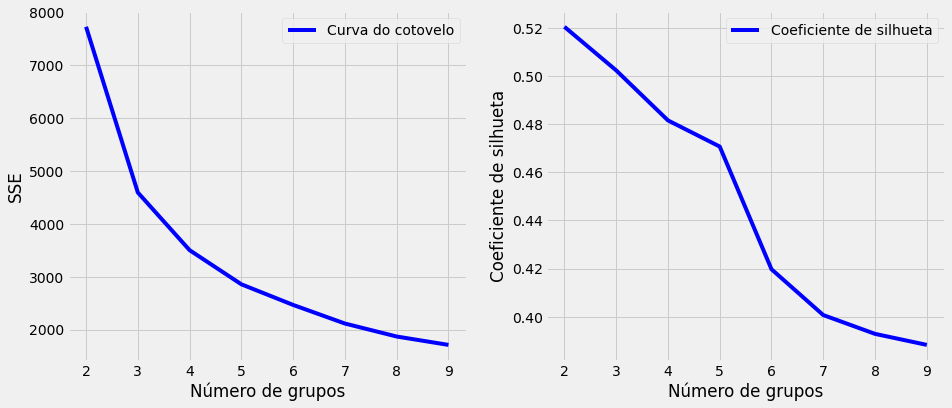

In [220]:
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize=(14,6))
fig.add_subplot(121)
plt.plot(range_n_clusters, elbow,'b-',label='Curva do cotovelo')
plt.xlabel("Número de grupos")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(122)
plt.plot(range_n_clusters, ss,'b-',label='Coeficiente de silhueta')
plt.xlabel("Número de grupos")
plt.ylabel("Coeficiente de silhueta")
plt.legend()
plt.show()

In [221]:
#Método do cotovelo para o dataframe RFME
range_n_clusters = [i for i in range(2,10)]
elbow = []
ss = []
for n_clusters in range_n_clusters:
   clusterer = KMeans(n_clusters = n_clusters, random_state=42, init='k-means++')
   cluster_labels = clusterer.fit_predict(rfme)
   silhouette_avg = silhouette_score(rfme, cluster_labels)
   ss.append(silhouette_avg)
   print("Número de grupos =", n_clusters,"Coef. de Silhouette =", round(silhouette_avg, 4))
   elbow.append(clusterer.inertia_) 

Número de grupos = 2 Coef. de Silhouette = 0.3986
Número de grupos = 3 Coef. de Silhouette = 0.3831
Número de grupos = 4 Coef. de Silhouette = 0.4131
Número de grupos = 5 Coef. de Silhouette = 0.4054
Número de grupos = 6 Coef. de Silhouette = 0.4086
Número de grupos = 7 Coef. de Silhouette = 0.3714
Número de grupos = 8 Coef. de Silhouette = 0.3416
Número de grupos = 9 Coef. de Silhouette = 0.3457


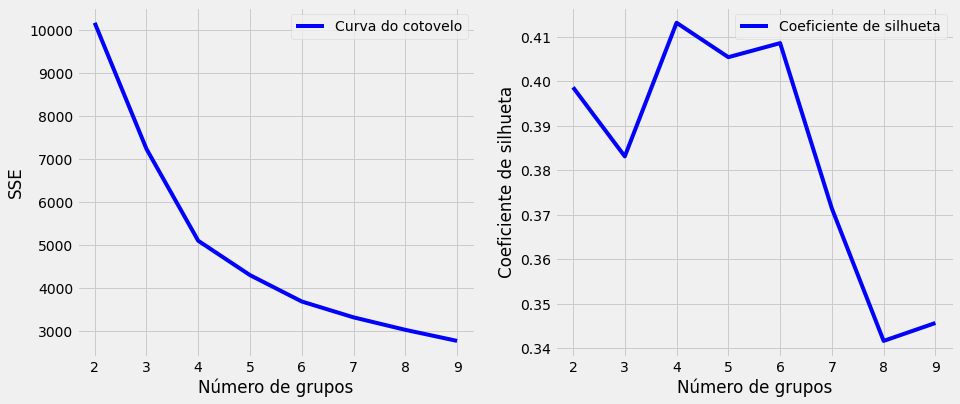

In [222]:
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize=(14,6))
fig.add_subplot(121)
plt.plot(range_n_clusters, elbow,'b-',label='Curva do cotovelo')
plt.xlabel("Número de grupos")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(122)
plt.plot(range_n_clusters, ss,'b-',label='Coeficiente de silhueta')
plt.xlabel("Número de grupos")
plt.ylabel("Coeficiente de silhueta")
plt.legend()
plt.show()

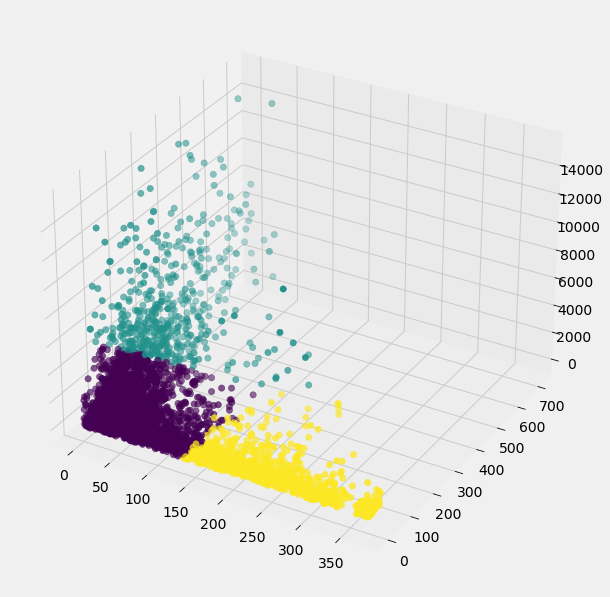

In [250]:
model = KMeans(n_clusters = 3, random_state=42, init='k-means++')
cluster_labels = model.fit_predict(rfm)


rfm_dataframe['Segmentacao'] = cluster_labels + 1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(rfm_dataframe['Recencia'])
y = np.array(rfm_dataframe['Frequencia'])
z = np.array(rfm_dataframe['Montante'])

ax.scatter(x, y, z, c=rfm_dataframe["Segmentacao"], s=40)

plt.show()

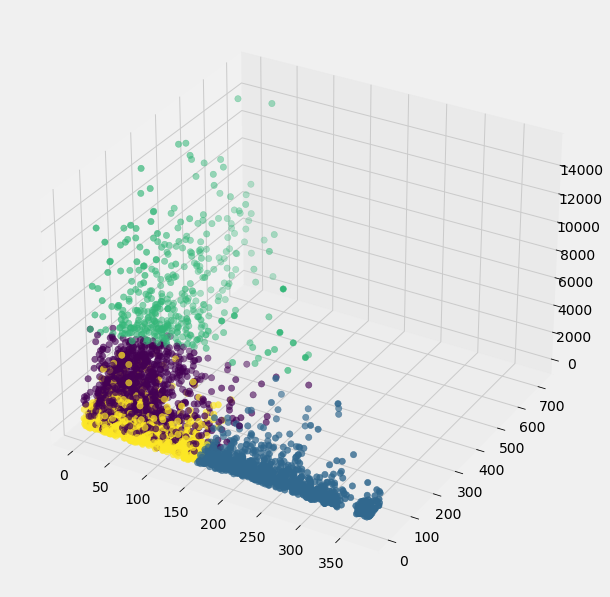

In [251]:
model = KMeans(n_clusters = 4, random_state=42, init='k-means++')
cluster_labels = model.fit_predict(rfme)

rfme_dataframe['Segmentacao'] = cluster_labels + 1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(rfme_dataframe['Recencia'])
y = np.array(rfme_dataframe['Frequencia'])
z = np.array(rfme_dataframe['Montante'])
w = np.array(rfme_dataframe['Elasticidade'])

ax.scatter(x, y, z, w, c=rfme_dataframe["Segmentacao"], s=40)

plt.show()

In [252]:
tabela_rfm = rfm_dataframe[['Segmentacao','Montante','Recencia','Frequencia']].groupby('Segmentacao').agg(['mean','count','min','max']).round()

tabela_rfme = rfme_dataframe[['Segmentacao','Montante','Recencia','Frequencia','Elasticidade']].groupby('Segmentacao').agg(['mean','count','min','max']).round()

In [253]:
tabela_rfm

Montante                       Recencia                  \
                mean count    min      max     mean count  min  max   
Segmentacao                                                           
1             1003.0  2707   11.0   6001.0     46.0  2707    0  168   
2             5127.0   512  961.0  15139.0     30.0   512    0  289   
3              444.0  1012    0.0   6799.0    244.0  1012  135  373   

            Frequencia                 
                  mean count min  max  
Segmentacao                            
1                 61.0  2707   1  258  
2                279.0   512   1  712  
3                 27.0  1012   1  259

In [254]:
tabela_rfme

Montante                        Recencia                  \
                mean count     min      max     mean count  min  max   
Segmentacao                                                            
1             1606.0  1437    43.0   6702.0     42.0  1437    0  216   
2              448.0   948     0.0   6799.0    251.0   948  153  373   
3             5791.0   387  1353.0  15139.0     28.0   387    0  289   
4              560.0  1459     4.0   6001.0     55.0  1459    0  157   

            Frequencia                Elasticidade                 
                  mean count min  max         mean count min  max  
Segmentacao                                                        
1                 96.0  1437   2  349        254.0  1437  40  373  
2                 27.0   948   1  259         24.0   948   0  196  
3                304.0   387   1  712        296.0   387   0  373  
4                 36.0  1459   1  287         33.0  1459   0  188

## Análise de grupos

In [ ]:
df_model['Grupos'] = df_model['Segmentacao'].replace({1:'Sumidos',
                                           3:'Sumidos',
                                           6:'Sumidos',
                                           5:'Casuais',
                                           4:'Casuais',
                                           2:'Novos clientes',
                                           7:'Casuais campeões',
                                           8:'Fieis',
                                           9:'Campões'})


df_model['Grupos_num'] = df_model['Segmentacao'].replace({1:1,
                                           3:1,
                                           6:1,
                                           5:2,
                                           4:2,
                                           2:3,
                                           7:4,
                                           8:5,
                                           9:6})

In [255]:
# fig = plt.figure(figsize=(20,5))
# ax = fig.add_subplot(121)
# plt.scatter(x = df_model['Frequencia'], y = df_model['Recencia'], c=df_model['Grupos_num'])
# ax.set_xlabel('Frequencia')
# ax.set_ylabel('Recencia')

# ax = fig.add_subplot(122)
# plt.scatter(x = df_model['Frequencia'], y = df_model['Montante'], c=df_model['Grupos_num'])
# ax.set_xlabel('Frequencia')
# ax.set_ylabel('Montante')
# plt.show()

In [256]:
# fig = plt.figure(figsize=(20,5))
# ax = fig.add_subplot(121)
# plt.scatter(x = df_model['Frequencia'], y = df_model['LTV'], c=df_model['Grupos_num'])
# ax.set_xlabel('Frequencia')
# ax.set_ylabel('Montante')

# ax = fig.add_subplot(122)
# plt.scatter(x = df_model['Recencia'], y = df_model['LTV'], c=df_model['Grupos_num'])
# ax.set_xlabel('Frequencia')
# ax.set_ylabel('Montante')
# plt.show()